In [39]:
import numpy as np
import pandas as pd
import os, re, codecs

from tqdm import tqdm

from sklearn.model_selection import train_test_split


import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping


### Parsing the FastText word-embeddings file

In [33]:
# Load FastText embeddings
print('Loading word embeddings...')

embeddings_index = {}
f = codecs.open('./wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Loading word embeddings...


999995it [02:04, 8035.48it/s]


found 999995 word vectors


### Tokenizing the text

In [2]:
data_dir = "dlnn/datasets"

In [3]:
df = pd.read_csv(os.path.join(data_dir, "df_final.csv"))

In [4]:
df_X = df["comment_text"]
df_Y = df["target_dis"]

In [5]:
df_X.shape, df_Y.shape

((1080220,), (1080220,))

In [34]:
## Perhaps preprocessing would improved results

In [19]:
df['doc_len'] = df['comment_text'].apply(lambda words: len(words.split(" ")))

In [22]:
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
max_seq_len

100

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2)

In [23]:
maxwords = 10000

In [24]:
tokenizer = Tokenizer(num_words = maxwords)# Creates a tokenizer, configured to only take into account the 1,000 most common words
tokenizer.fit_on_texts(df_X)# Builds the word index

train_samples = tokenizer.texts_to_sequences(X_train)# Turn strings into lists of integer indices
test_samples = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  302139


In [25]:
train_data = pad_sequences(train_samples, padding='post', maxlen=max_seq_len)# Turns the lists of integers into a 2D tensor of shape (samples, maxlen)
test_data = pad_sequences(test_samples, padding='post', maxlen=max_seq_len)

### Training and model parameters

In [69]:
# Training params
batch_size = 256
num_epochs = 4

# Model parameters
num_filters = 64
embed_dim = 300
weight_decay = 1e-4

### Preparing the FastText word-embeddings matrix

In [35]:
print('Preparing embedding matrix...')

words_not_found = []
nb_words = min(maxwords, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix...
number of null word embeddings: 272


In [38]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ["should've" 'pmo' "today's" 'pmo' 'rrsp' 'imua' 'wynne' "y'all" "wasn't"
 "here's"]


In [42]:
# The above suggests preprocessing would be beneficial: NO

In [37]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0897    ,  0.016     , -0.0571    , ...,  0.1559    ,
        -0.0254    , -0.0259    ],
       [ 0.0495    ,  0.0411    ,  0.0041    , ...,  0.23710001,
        -0.0298    , -0.0284    ],
       ...,
       [ 0.1393    , -0.14309999,  0.0518    , ...,  0.1166    ,
        -0.0908    , -0.0141    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.3073    , -0.0712    , -0.1532    , ..., -0.0764    ,
         0.1076    , -0.1471    ]])

### Model definition

In [63]:
# CNN architecture
print("Training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
                   weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 64)           134464    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0   

In [54]:
model.save("model_CNN_v1.h5")
print("Saved model to disk")

Saved model to disk


In [55]:
#define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]

In [65]:
#model training
# hist = model.fit(train_data, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)
hist = model.fit(train_data, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, shuffle=True, verbose=2)

Train on 777758 samples, validate on 86418 samples
Epoch 1/4
 - 89s - loss: 0.5289 - acc: 0.7421 - val_loss: 0.5030 - val_acc: 0.7559
Epoch 2/4
 - 90s - loss: 0.5048 - acc: 0.7580 - val_loss: 0.5000 - val_acc: 0.7588
Epoch 3/4
 - 90s - loss: 0.4937 - acc: 0.7644 - val_loss: 0.5005 - val_acc: 0.7544
Epoch 4/4
 - 90s - loss: 0.4840 - acc: 0.7694 - val_loss: 0.5020 - val_acc: 0.7565


In [66]:
hist.history

{'val_loss': [0.5029820539897857,
  0.5000340954349021,
  0.5004704021105882,
  0.5019688627105693],
 'val_acc': [0.7558726191206177,
  0.7587886782625455,
  0.7544261612384845,
  0.7564859172512645],
 'loss': [0.5288812481187154,
  0.5048169572076663,
  0.49366951086373767,
  0.4840164707851944],
 'acc': [0.7421202996309362,
  0.7579517022010405,
  0.7643778656079695,
  0.7694385657229154]}

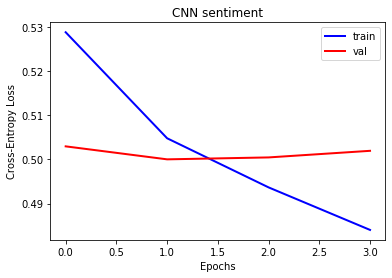

In [67]:
import matplotlib.pyplot as plt

#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

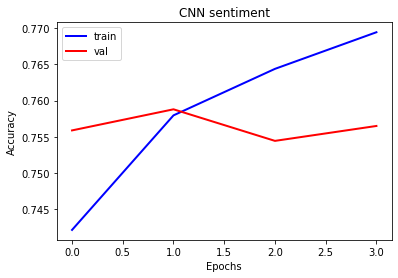

In [68]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()